## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import warnings

warnings.filterwarnings('ignore')

## Exploring the tables in the database

In [2]:
conn = sqlite3.connect('/home/yeachan153/Desktop/BDS/Python/Datasets/factbook.db')
query = "SELECT * FROM sqlite_master WHERE type = 'table'"
tables = pd.read_sql_query(query, conn)

print(tables)

    type             name         tbl_name  rootpage  \
0  table  sqlite_sequence  sqlite_sequence         3   
1  table            facts            facts        47   
2  table           cities           cities         2   

                                                 sql  
0             CREATE TABLE sqlite_sequence(name,seq)  
1  CREATE TABLE "facts" ("id" INTEGER PRIMARY KEY...  
2  CREATE TABLE cities (\n        id integer prim...  


#### Or we could return it as a list of nested tuples

In [3]:
conn.execute(query).fetchall()

[('table',
  'sqlite_sequence',
  'sqlite_sequence',
  3,
  'CREATE TABLE sqlite_sequence(name,seq)'),
 ('table',
  'facts',
  'facts',
  47,
  'CREATE TABLE "facts" ("id" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, "code" varchar(255) NOT NULL, "name" varchar(255) NOT NULL, "area" integer, "area_land" integer, "area_water" integer, "population" integer, "population_growth" float, "birth_rate" float, "death_rate" float, "migration_rate" float)'),
 ('table',
  'cities',
  'cities',
  2,
  'CREATE TABLE cities (\n        id integer primary key,\n        name text,\n        population integer,\n        capital bool,\n        facts_id text,\n        foreign key(facts_id) references facts(id)\n    )')]

## Exploring the "facts" table

In [4]:
# Returning the first 5 rows
query = "SELECT * FROM facts LIMIT 5"
print(pd.read_sql_query(query,conn))

   id code         name     area  area_land  area_water  population  \
0   1   af  Afghanistan   652230     652230           0    32564342   
1   2   al      Albania    28748      27398        1350     3029278   
2   3   ag      Algeria  2381741    2381741           0    39542166   
3   4   an      Andorra      468        468           0       85580   
4   5   ao       Angola  1246700    1246700           0    19625353   

   population_growth  birth_rate  death_rate  migration_rate  
0               2.32       38.57       13.89            1.51  
1               0.30       12.92        6.58            3.30  
2               1.84       23.67        4.31            0.92  
3               0.12        8.13        6.96            0.00  
4               2.78       38.78       11.49            0.46  


### Getting basic summaries

In [5]:
query = ("SELECT MIN(population) \"Minimum Population\", MAX(population) \"Maximum Population\", MIN(population_growth) \"Minimum pop growth (%)\", MAX(population_growth) \"Max pop growth (%)\" "
         "FROM facts")

conn.cursor().execute(query).fetchall() # The long way
conn.execute(query).fetchall() # The shorter way
pd.read_sql_query(query, conn) # THe shortest way

,Minimum Population,Maximum Population,Minimum pop growth (%),Max pop growth (%)
0,0,7256490011,0.0,4.02


There are some odd results here. There can't be a country with a population of zero, and there are no countries with a population of 7 billion. 

In [6]:
# Using subqueries
query = ("SELECT name \"Country with zero population\" "
         "FROM facts "
         "WHERE population = (SELECT MIN(population) FROM facts)")

query2 = ("SELECT name \"Country with 7 billion people\" "
          "FROM facts "
          "WHERE population = (SELECT MAX(population) FROM facts)")

print(pd.read_sql_query(query, conn))
print(pd.read_sql_query(query2, conn))

  Country with zero population
0                   Antarctica
  Country with 7 billion people
0                         World


Seems like the table mistakenly suggests Antarctica has a population of zero. It also seems to have recorded the world as a country.

### Visualising population data (without 'World' and 'Antarctica')

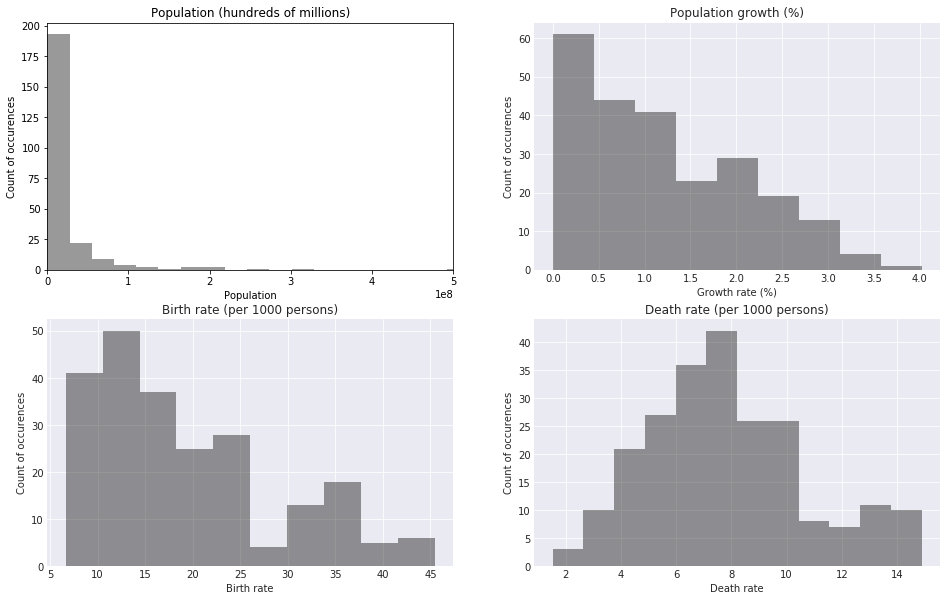

In [7]:
%matplotlib inline

query = ("SELECT population, population_growth, birth_rate, death_rate "
         "FROM facts "
         "WHERE population != (SELECT MIN(population) FROM facts) AND population != (SELECT MAX(population) FROM facts)")

data = pd.read_sql_query(query,conn)
cols = list(data)
title = ['Population (hundreds of millions)', 'Population growth (%)', 'Birth rate (per 1000 persons)', 
         'Death rate (per 1000 persons)']
xaxis = ['Population', 'Growth rate (%)', 'Birth rate', 'Death rate']

fig = plt.figure(figsize = (16,10))
for i in range(len(cols)):
    ax = fig.add_subplot(2,2,i+1)
    if i == 0:
        ax.set_xlim(0,0.5e9) # In hundreds of millions
    sns.distplot(data[cols[i]].dropna(), kde = False, color = 'Black')
    sns.set_style('darkgrid')
    ax.set_title(title[i])
    ax.set_ylabel('Count of occurences')
    ax.set_xlabel(xaxis[i])

The majority of countries seem to have a population between 0-100 million. The growth rate of countries seems to range from 0-4%. The majority of birthrates seem to be around 7-25 births per 1000 people, whereas for deathrates, that figure drops to around 5-10 deaths per 1000 people. Birthrate and deathrate calculations are per year.

### Countries with a high water to land proportion

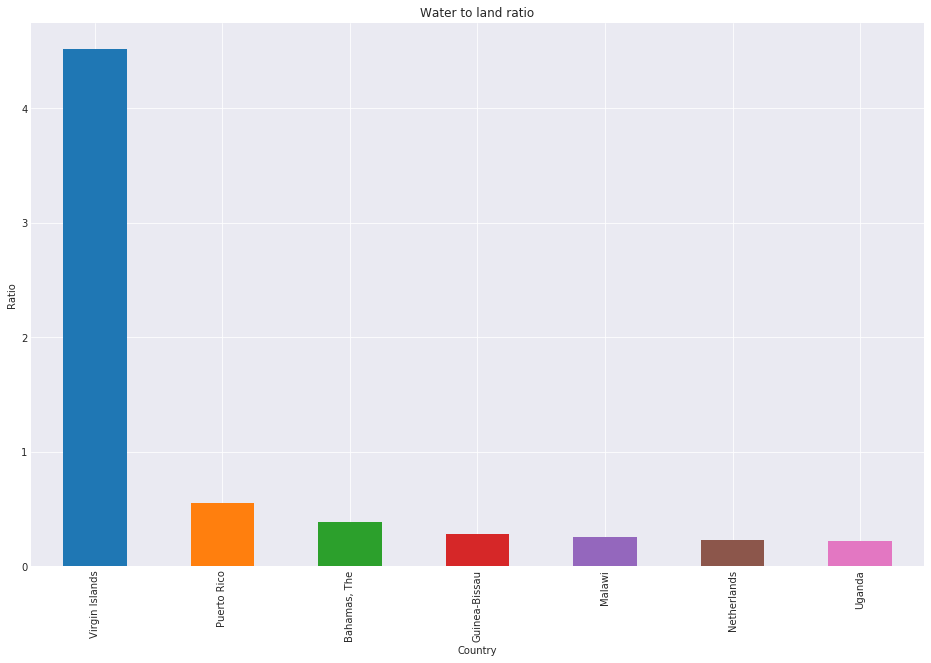

In [8]:
query = ("SELECT name Country, CAST(area_water as FLOAT)/area_land ratio "
         "FROM facts "
         "GROUP BY Country "
         "HAVING ratio > 0.2 "
         "ORDER BY ratio DESC"
         )

ax = pd.read_sql_query(query, conn).iloc[1:].plot.bar(x='Country', y = 'ratio',
                      title = 'Water to land ratio', legend = False, figsize = (16,10))
ax.set_ylabel('Ratio')
sns.set_style('darkgrid')

Here, I show countries with water to land ratios greater than 0.2. I excluded the first country as the ratio of the British Indian Ocean Territory exceeded 900.

### Exploring population density

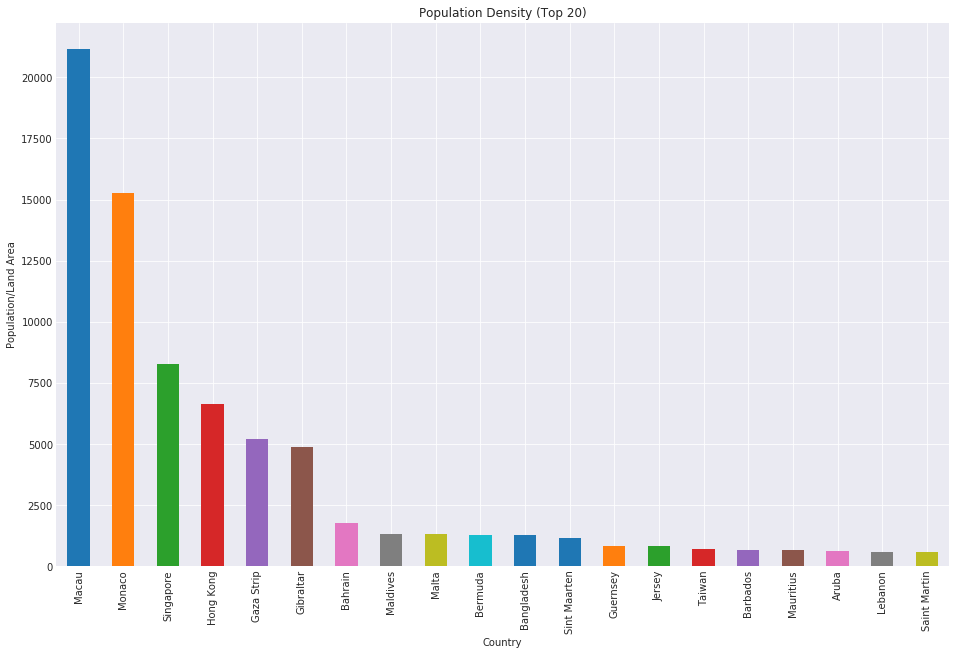

In [9]:
query = ("SELECT name Country, population/area_land pop_density "
         "FROM facts "
         "ORDER BY pop_density DESC "
         "LIMIT 20")

ax = pd.read_sql_query(query, conn).plot.bar(x = 'Country', y = 'pop_density', 
                 title = 'Population Density (Top 20)', figsize = (16,10), legend = False)
ax.set_ylabel('Population/Land Area')
plt.show()

Here, we can see that the most populated countries in the world are Monaco, Singamore and Hong Kong. Macau is not included as it is an administrative region of the PRC.

## Joining the "facts" and "cities" table

In [11]:
query = "SELECT * FROM cities LIMIT 3"
pd.read_sql_query(query, conn)

,id,name,population,capital,facts_id
0,1,Oranjestad,37000,1,216
1,2,Saint John'S,27000,1,6
2,3,Abu Dhabi,942000,1,184


As we can see, we can join the "cities" table to "facts" through the "facts_id" column in cities, which corresponds to the IDs in facts. As I don't want any missing data, I'll use inner join.

In [14]:
query = "SELECT * FROM facts f INNER JOIN cities c ON f.id = c.facts_id LIMIT 3"
pd.read_sql_query(query,conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,id,name,population,capital,facts_id
0,216,aa,Aruba,180,180,0,112162,1.33,12.56,8.18,8.92,1,Oranjestad,37000,1,216
1,6,ac,Antigua and Barbuda,442,442,0,92436,1.24,15.85,5.69,2.21,2,Saint John'S,27000,1,6
2,184,ae,United Arab Emirates,83600,83600,0,5779760,2.58,15.43,1.97,12.36,3,Abu Dhabi,942000,1,184


### Gaining new insights by joinIng data (also subqueries)

In [39]:
query = ("SELECT f.name Country, c.urban_pop \"Urban Population\", f.population \"Total Population\", ROUND(CAST(c.urban_pop as FLOAT)/f.population*100, 2) \"Urban Population %\" "
         "FROM facts f "
         "INNER JOIN (SELECT f.name Country, SUM(c.population) urban_pop FROM facts f INNER JOIN cities c on c.facts_id = f.id GROUP BY f.name ORDER BY 1) "
         "c ON f.name = c.Country "
         "WHERE \"Urban Population %\" > 50 "
         "ORDER BY \"Urban Population %\" ASC"
         )

pd.read_sql_query(query,conn)

,Country,Urban Population,Total Population,Urban Population %
0,Uruguay,1672000,3341893,50.03
1,"Congo, Republic of the",2445000,4755097,51.42
2,Brunei,241000,429646,56.09
3,New Caledonia,157000,271615,57.80
4,Virgin Islands,60000,103574,57.93
5,Falkland Islands (Islas Malvinas),2000,3361,59.51
6,Djibouti,496000,828324,59.88
7,Australia,13789000,22751014,60.61
8,Iceland,206000,331918,62.06
9,Israel,5226000,8049314,64.92


Here, I combined data from both tables to calculate which countries seem to have most of their population centered around their major cities. I only included countries where the total urban population exceeded 50% of the total country population.